In [1]:
# Dependencies
import requests
import json
from citipy import citipy
import numpy as np
from config import owkey
import geoip2.database
import geoip2.webservice
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [259]:
#Read a CSV file with data on cities around the world
file="worldcitiespop_reduced.csv"
cities_df=pd.read_csv(file)

In [260]:
#Create a simplified dataframe with 500 cities randomly sampled (without replacement) from the CSV file
simpcities_df = cities_df[["Latitude","Longitude"]]
cities_dict=simpcities_df.set_index("Latitude")["Longitude"].to_dict()
random_500=dict(random.sample(cities_dict.items(), 500))

In [261]:
#Collect the weather data from 500 cities

weather_df= pd.DataFrame({
    "Name": [], 
    "Temperature (F)": [],  
    "Humidity (%)": [], 
    "Cloudiness (%)": [], 
    "Windspeed (mph)": [], 
    
})


call_counter=0
for lat in random_500:
    api_call = "http://api.openweathermap.org/data/2.5/weather?lat=" + str(lat) + "&lon=" + str(random_500[lat]) + "&units=imperial" + "&appid=" + owkey
    api_response = requests.get(api_call)
    api_json = api_response.json()
    name=api_json["name"]
    temp=api_json["main"]["temp"]
    humidity=api_json["main"]["humidity"]
    clouds=api_json["clouds"]["all"]
    speed=api_json["wind"]["speed"]
    
    #append the weather values to the dataframe
    weather_df=weather_df.append({'Name' : name , 'Temperature (F)' : temp, "Humidity (%)": humidity, "Cloudiness (%)": clouds, "Windspeed (mph)": speed, "Latitude": lat, "Longitude": random_500[lat] } , ignore_index=True)
    
    call_counter+=1
    if call_counter==19:
        time.sleep(1)
        call_counter=0
        
        continue

In [262]:
#Create a new column that turns latitude into distance from the equator to facilitate analysis
weather_df["Distance From Equator"]=abs(weather_df["Latitude"])
weather_df.head()

,Name,Temperature (F),Humidity (%),Cloudiness (%),Windspeed (mph),Latitude,Longitude,Distance From Equator
0,Shangzhou,64.60,28.0,1.0,7.31,33.885556,109.807778,33.885556
1,Montville,45.77,100.0,80.0,5.82,49.570980,1.109358,49.570980
2,Corbreuse,51.26,80.0,0.0,1.01,48.530432,1.955705,48.530432
3,Laboulaye,60.58,74.0,0.0,9.46,-34.235925,-63.423520,34.235925
4,San Pedro de Atacama,42.13,49.0,0.0,1.59,-23.550000,-67.900000,23.550000
...,...,...,...,...,...,...,...,...
495,Akhalk'alak'i,40.14,68.0,98.0,2.73,41.353611,43.429722,41.353611
496,Hetzbach,48.07,52.0,0.0,0.92,49.588611,8.966944,49.588611
497,Udías,51.67,95.0,0.0,3.74,43.337422,-4.248277,43.337422
498,Daqiao,63.88,42.0,100.0,25.08,41.493889,120.612500,41.493889


In [263]:
#Create separate dataframes for the northern and southern hemispehres only
Nweather_df=weather_df.loc[weather_df["Latitude"]>0]
Sweather_df=weather_df.loc[weather_df["Latitude"]<=0]

In [303]:
#Prepare the written analyses that I would like to present on each chart
#I recognize at this point that I should have just made this in markdown format, but I wanted
#the text to appear after each chart to look fancy so I did this instead.

def wind_analysis():
    print("While the relationship between windspeed and distance from the equator may appear diproportionately weak, ")
    print("The variation in windspeed decreases as one gets further to the equator. This may be ")
    print("because the speed at which any given point on the surface at the earth moves increases ")
    print("as it's distance to the equator decreases. This is one of the properties of spinning")
    print("objects: points further from the axis of rotation along the same plane move faster")
    print("than points nearer to the center. This produces the wind pattern we see here, known as the")
    print("coriolis effect.")
    
def humid_analysis():
    print("While the relationship between humidity and distance from the equator appears weak, ")
    print("The variation in humidity increases as one gets further from the equator. This may be ")
    print("because cities near the equator are more uniformly dry, wheras further locations ")
    print("experience more precipitation and more erratic weather. The author's knowledge on this subject is limited, however.")

    
def temp_analysis():
    print("The relationship between distance from the equator and temperature is well-known.)")
    print("Areas on the globe which get more direct rays from the sun, near the equator become")
    print("warmer than areas with less direct rays, near the poles. \n")
    print("There is, however, another interesting pattern here. There might be a second")
    print("relationship associated with an exteranious variable, as indicated by the cluster of points on this ")
    print("scatterplot beginning at about 47 degrees latitude and converging with the first regression line at high .")
    print("latitude values. This variable is probably not hemisphere, since we see the same pattern in both")
    print("northern and southern hemispheres when we isolate that data (see separate charts below for data from ")
    print("cities in northern and southern hemispheres only.) This second relationship is consistent regardless")
    print("of the number of times the analysis is run, and since the analysis samples cities randomly,")
    print("It is unlikely that this pattern in the data is due to chance.")
    
def cloud_analysis():
    print("The relationship between cloudiness and distance from the equator appears weak or nonexistent.")
    print("If there is any true substantive relationship between distance from the equator and cloudiness, it is ")
    print("not easily discernable from this analysis. Breaking down the data by hemisphere does not seem to help ")
    print("because the direction of the relationship between cloudiness and latitude changes in the southern ")
    print("hemisphere more than five percent of the time when the analysis is re-run repeatedly (test it for yourself!).")
    print("This apparent change in the direction of the relationship might due to the fact that there are less ")
    print("cities in the southern hemisphere. Smaller samples havehigher levels of variation, so we ")
    print("shouldn't be surprised to see aparent strong relationships in either direction even when no true substantive relationship exists.")
    


In [298]:
#Define a function that will conduct all of my regression analyses for both hemispeheres, the northern hemisphere,
#and the southern hemisphere, then print the analysis I prepared above.

def regIV(a,l):
    if l=="b":
        dataframe= weather_df[[a, "Distance From Equator"]]
    elif l=="n":
        dataframe= Nweather_df[[a, "Distance From Equator"]]
    elif l=="s":
        dataframe= Sweather_df[[a, "Distance From Equator"]]
    else:
        print("Something went wrong!")
    dataframe.plot.scatter( x=[a] , y=["Distance From Equator"])
    
    x= dataframe[[a]]
    y= dataframe[["Distance From Equator"]]
    
    model=LinearRegression()
    model.fit(x,y)
    beta=model.coef_
    alpha=model.intercept_
    yline=model.predict(x)
    plt.scatter(x,y)
    plt.plot(x, yline,"r")
    Rsquare=r2_score(y, yline)

    if l=="b":
        plt.title(f"{a} by Distance From Equator in 500 Worldwide Cities")
        plt.xlabel("Distance From Equator")
        plt.ylabel(a)
    elif l=="n":
        plt.title(f"{a} by Distance From Equator in Only Northern Hemisphere Cities")
        plt.xlabel("Distance From Equator")
        plt.ylabel(a)
    elif l=="s":
        plt.title(f"{a} by Distance From Equator in Only Southern Hemisphere Cities")
        plt.xlabel("Distance From Equator")
        plt.ylabel(a)

    plt.show()

#----Display coeficient, intercept, and R^2
    print(f"\u03B2 ={beta}")
    print(f"\u03B1 ={alpha}")
    print(f"R^2={Rsquare}")
    
#----Print an analysis   
    what_crease=[]
    direction=[]
    IVdir="greater"
    DVdir=[]
    if beta<0:
        what_crease="decrease"
        direction="negative"
        DVdir="lower"
    elif beta==0:
        what_crease="increase"
        direction="lack of any"
        DVdir="no change"
    else:
        what_crease="increase"
        direction="positive"
        IVdir="greater"
        DVdir="higher"
    


    
    print(f"\nThis chart is displaying the relationship between {a.lower()} and the distance a city ")
    print(f"is from the equator. The regression coefficient is {beta}, a {direction} association.")
    print(f"This means that for every one degree increase in latitude a city is from ")
    print(f"the equator, the model predicts a {abs(beta)} unit {what_crease} in {a.lower()}. \n")
    print(f"In other words, {IVdir} distances from the equator are associated with {DVdir} {a.lower()}.\n")
    
    if a=="Windspeed (mph)" and l=="b":
        wind_analysis()
    elif a=="Temperature (F)" and l=="b":
        temp_analysis()
    elif a=="Cloudiness (%)" and l=="b":
        cloud_analysis()
    elif a=="Humidity (%)" and l=="b":
        humid_analysis()
    else:
        print("See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.")

In [299]:
#Generate a list of independent variables that I can plug into my massive function
IVlist=[value for value in weather_df.columns[range(1,5)]]

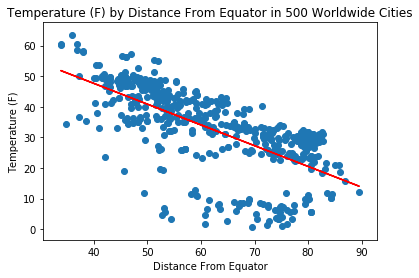

β =[[-0.67849784]]
α =[74.77044067]
R^2=0.4530920939757278

This chart is displaying the relationship between temperature (f) and the distance a city 
is from the equator. The regression coefficient is [[-0.67849784]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.67849784]] unit decrease in temperature (f). 

In other words, greater distances from the equator are associated with lower temperature (f).

The relationship between distance from the equator and temperature is well-known.)
Areas on the globe which get more direct rays from the sun, near the equator become
warmer than areas with less direct rays, near the poles. 

There is, however, another interesting pattern here. There might be a second
relationship associated with an exteranious variable, as indicated by the cluster of points on this 
scatterplot beginning at about 47 degrees latitude and converging with the first regression line at

<Figure size 432x288 with 0 Axes>

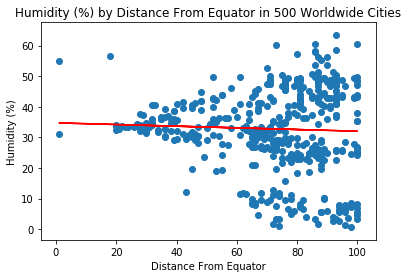

β =[[-0.02727631]]
α =[34.73962531]
R^2=0.0017934520738833726

This chart is displaying the relationship between humidity (%) and the distance a city 
is from the equator. The regression coefficient is [[-0.02727631]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.02727631]] unit decrease in humidity (%). 

In other words, greater distances from the equator are associated with lower humidity (%).

While the relationship between humidity and distance from the equator appears weak, 
The variation in humidity increases as one gets further from the equator. This may be 
because cities near the equator are more uniformly dry, wheras further locations 
experience more precipitation. The author's knowledge on this subject is limited, however.
Like the termperature analysis, this chart also seems to have a second relationship
That cannot be attributable to hemisphere for the same reasons.





<Figure size 432x288 with 0 Axes>

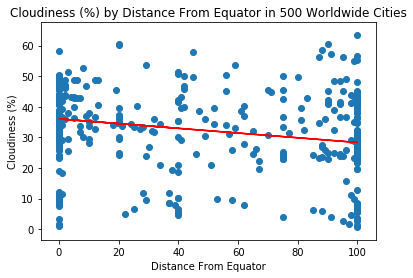

β =[[-0.07711655]]
α =[36.03307736]
R^2=0.061336822609596164

This chart is displaying the relationship between cloudiness (%) and the distance a city 
is from the equator. The regression coefficient is [[-0.07711655]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.07711655]] unit decrease in cloudiness (%). 

In other words, greater distances from the equator are associated with lower cloudiness (%).

The relationship between cloudiness and distance from the equator appears weak or nonexistent.
If there is any true substantive relationship between distance from the equator and cloudiness, it is 
not easily discernable from this analysis. Breaking down the data by hemisphere does not seem to help 
because the direction of the relationship between cloudiness and latitude changes in the southern 
hemisphere more than five percent of the time when the analysis is re-run repeatedly (test it for yourse

<Figure size 432x288 with 0 Axes>

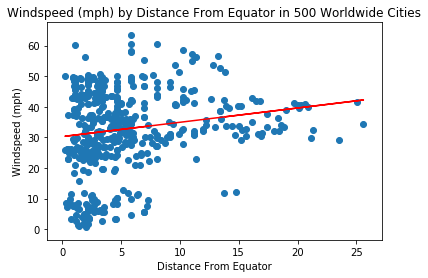

β =[[0.46807556]]
α =[30.24022277]
R^2=0.02726815919182779

This chart is displaying the relationship between windspeed (mph) and the distance a city 
is from the equator. The regression coefficient is [[0.46807556]], a positive association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.46807556]] unit increase in windspeed (mph). 

In other words, greater distances from the equator are associated with higher windspeed (mph).

While the relationship between windspeed and distance from the equator may appear diproportionately weak, 
The variation in windspeed decreases as one gets further to the equator. This may be 
because the speed at which any given point on the surface at the earth moves increases 
as it's distance to the equator decreases. This is one of the properties of spinning
objects: points further from the axis of rotation along the same plane move faster
than points nearer to the center. This produces the wi

<Figure size 432x288 with 0 Axes>

In [300]:
#Plug those babies in, and BOOM! Charts.
for items in IVlist:
    regIV(items,"b")
    for i in range (0,4):
        plt.savefig(f"regression{i}")
    print("\n"*2)

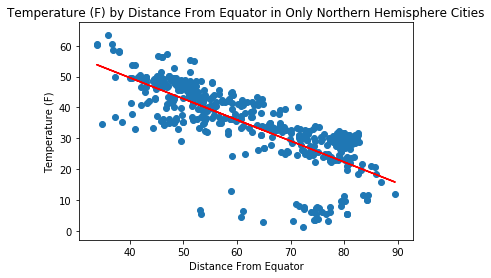

β =[[-0.68270153]]
α =[76.93000624]
R^2=0.5792579521073371

This chart is displaying the relationship between temperature (f) and the distance a city 
is from the equator. The regression coefficient is [[-0.68270153]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.68270153]] unit decrease in temperature (f). 

In other words, greater distances from the equator are associated with lower temperature (f).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

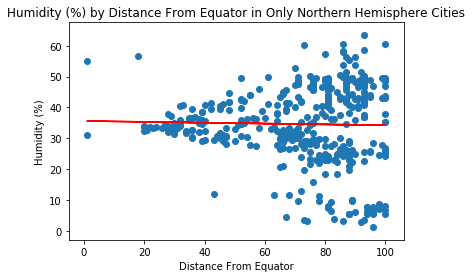

β =[[-0.01376086]]
α =[35.59732797]
R^2=0.0005733054861811748

This chart is displaying the relationship between humidity (%) and the distance a city 
is from the equator. The regression coefficient is [[-0.01376086]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.01376086]] unit decrease in humidity (%). 

In other words, greater distances from the equator are associated with lower humidity (%).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

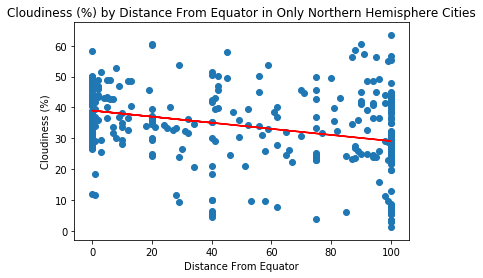

β =[[-0.09863685]]
α =[38.97151927]
R^2=0.11908537855689261

This chart is displaying the relationship between cloudiness (%) and the distance a city 
is from the equator. The regression coefficient is [[-0.09863685]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.09863685]] unit decrease in cloudiness (%). 

In other words, greater distances from the equator are associated with lower cloudiness (%).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

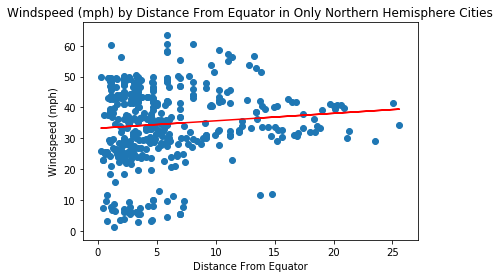

β =[[0.2423322]]
α =[33.23773184]
R^2=0.009050830100272633

This chart is displaying the relationship between windspeed (mph) and the distance a city 
is from the equator. The regression coefficient is [[0.2423322]], a positive association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.2423322]] unit increase in windspeed (mph). 

In other words, greater distances from the equator are associated with higher windspeed (mph).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

In [301]:
#Do it again, but for the Northern Hemisphere only
for items in IVlist:
    regIV(items,"n")
    for i in range (0,4):
        plt.savefig(f"Nregression{i}")
    print("\n"*2)

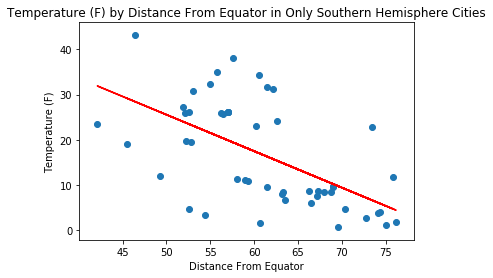

β =[[-0.8081029]]
α =[65.96308089]
R^2=0.3479397495137989

This chart is displaying the relationship between temperature (f) and the distance a city 
is from the equator. The regression coefficient is [[-0.8081029]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.8081029]] unit decrease in temperature (f). 

In other words, greater distances from the equator are associated with lower temperature (f).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

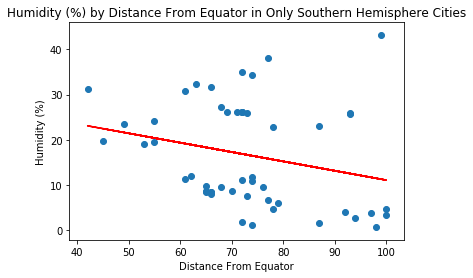

β =[[-0.20705873]]
α =[31.78066233]
R^2=0.06332350387017038

This chart is displaying the relationship between humidity (%) and the distance a city 
is from the equator. The regression coefficient is [[-0.20705873]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.20705873]] unit decrease in humidity (%). 

In other words, greater distances from the equator are associated with lower humidity (%).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

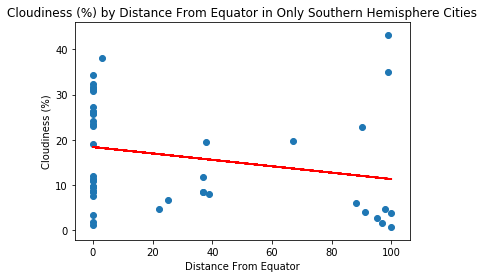

β =[[-0.07095965]]
α =[18.39285871]
R^2=0.05550526303789727

This chart is displaying the relationship between cloudiness (%) and the distance a city 
is from the equator. The regression coefficient is [[-0.07095965]], a negative association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[0.07095965]] unit decrease in cloudiness (%). 

In other words, greater distances from the equator are associated with lower cloudiness (%).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

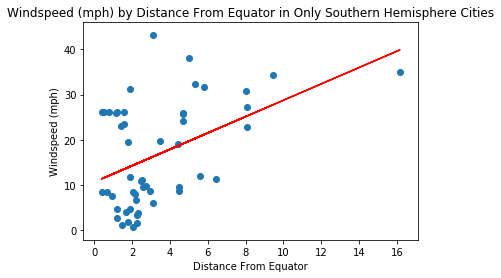

β =[[1.81013827]]
α =[10.64078349]
R^2=0.20104799366829573

This chart is displaying the relationship between windspeed (mph) and the distance a city 
is from the equator. The regression coefficient is [[1.81013827]], a positive association.
This means that for every one degree increase in latitude a city is from 
the equator, the model predicts a [[1.81013827]] unit increase in windspeed (mph). 

In other words, greater distances from the equator are associated with higher windspeed (mph).

See the analyses above on the relationships between variables in both hemispheres for commentary on these charts.





<Figure size 432x288 with 0 Axes>

In [302]:
#One more time, Southern Hemisphere
for items in IVlist:
    regIV(items,"s")
    for i in range (0,4):
        plt.savefig(f"Sregression{i}")
    print("\n"*2)